# Анализ пользователей и совершаемых ими покупок


## Описание данных:

####  Таблица с уникальными идентификаторами пользователей (olist_customers_datase.csv):

| Поле                     | Описание                                                                              |
| :------------------------| :-------------------------------------------------------------------------------------|
| customer_id              | позаказный идентификатор пользователя (аналог номера паспорта)                        |
| customer_unique_id       | уникальный идентификатор пользователя                                                 |
| customer_zip_code_prefix | почтовый индекс пользователя                                                          |
| customer_city            | город доставки пользователя                                                           |
| customer_state           | штат доставки пользователя                                                            |

####  Таблица заказов (olist_orders_dataset.csv):

| Поле                          | Описание                                                                         |
| :-----------------------------| :--------------------------------------------------------------------------------|
| order_id                      | уникальный идентификатор заказа (номер чека)                                     |
| customer_id                   | позаказный идентификатор пользователя (аналог номера паспорта)                   |
| order_status                  | статус заказа                                                                    |
| order_purchase_timestamp      | время создания заказа                                                            |
| order_approved_at             | время подтверждения оплаты заказа                                                |
| order_delivered_carrier_date  | время передачи заказа в логистическую службу                                     |
| order_delivered_customer_date | время доставки заказа                                                            |
| order_estimated_delivery_date | обещанная дата доставки                                                          |

####  Товарные позиции, входящие в заказы (olist_order_items_dataset.csv):

| Поле                   | Описание                                                                         |
| :----------------------| :--------------------------------------------------------------------------------|
| order_id               | уникальный идентификатор заказа (номер чека)                                     |
| order_item_id          | идентификатор товара внутри одного заказа                                        |
| product_id             | ид товара (аналог штрихкода)                                                     |
| seller_id              | ид производителя товара                                                          |
| shipping_limit_date    | максимальная дата доставки продавцом для передачи заказа партнеру по логистике   |
| price                  | цена за единицу товара                                                           |
| freight_value          | время доставки заказа                                                            |

#### Уникальный статусы заказов в таблице olist_order_items_dataset:

| Статус       | Описание                  |
| :------------| :-------------------------|
| created      | создан                    |
| approved     | подтверждён               |
| invoiced     | выставлен счёт            |
| processing   | в процессе сборки заказа  |
| shipped      | отгружен со склада        |
| delivered    | доставлен пользователю    |
| unavailable  | недоступен                |
| canceled     | отменён                   |

## Задачи:

**1) Сколько у нас пользователей, которые совершили покупку только один раз?**

**2) Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?**

**3) По каждому товару определить, в какой день недели товар чаще всего покупается.**

**4) Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.**

**5) Реализовать функцию, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.**

**6) Построить RFM-кластеры для пользователей. Вывести для каждого кластера средние значения метрик R, F, M (и описать подробно, как были построены метрики R, F, M).**

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
from operator import attrgetter
import datetime as dt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Считывание данных по пользователям

In [2]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
customers = pd.read_csv('olist_customers_dataset.csv')
print(f'Размерность данных "customers" - {customers.shape}')
customers.head()

Размерность данных "customers" - (99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [3]:
# Посмотрим на типы данных в датафрейме
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [4]:
# Посмотрим есть ли пропущенные значения в данных
miss_customers = customers.isna().sum()
miss_customers[miss_customers > 0]

Series([], dtype: int64)

In [5]:
# Посмотрим есть ли дубликаты строк в датафрейме
customers.duplicated().sum()

0

In [6]:
# Посмотрим на описательную статистику по строковым столбцам
customers[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']].describe().T

,count,unique,top,freq
customer_id,99441,99441,a9724796025983a341f8ed1fa6165cf9,1
customer_unique_id,99441,96096,8d50f5eadf50201ccdcedfb9e2ac8455,17
customer_city,99441,4119,sao paulo,15540
customer_state,99441,27,SP,41746


- Количество уникальных пользователей - 96 096, при этом пользователь с id ```8d50f5eadf50201ccdcedfb9e2ac8455``` встречается чаще всего;
- Количество уникальных городов доставки - 4 119, при этом наиболее часто встречающееся значение ```sao paulo``` - 15 540;
- Количество уникальных штатов доставки - 27, при этом наиболее часто встречающееся значение ```SP``` - 41 746.

## Считывание данных по заказам

In [7]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
orders = pd.read_csv('olist_orders_dataset.csv',
                     parse_dates=['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date', 
                                  'order_delivered_customer_date', 'order_estimated_delivery_date'])
print(f'Размерность данных "orders" - {orders.shape}')
orders.head()

Размерность данных "orders" - (99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [8]:
# Посмотрим на типы данных в датафрейме
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [9]:
# Посмотрим есть ли пропущенные значения в данных
miss_orders = orders.isna().sum()
miss_orders[miss_orders > 0]

order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

In [10]:
# Посмотрим есть ли дубликаты строк в датафрейме
orders.duplicated().sum()

0

In [11]:
# Посмотрим на описательную статистику по строковым столбцам
orders[['order_id', 'customer_id', 'order_status']].describe().T

,count,unique,top,freq
order_id,99441,99441,7e72165c5aea9996c625cfe62c8e1500,1
customer_id,99441,99441,a9724796025983a341f8ed1fa6165cf9,1
order_status,99441,8,delivered,96478


**В данных по заказам есть отсутствующие значения:**

| Поле                          | Количество  |
| :-----------------------------|:-----------:|
| order_approved_at             | 160         |
| order_delivered_carrier_date  | 1783        |
| order_delivered_customer_date | 2965        |


Попробуем разобраться с чем это связано. Для начала рассмотрим поле ```order_approved_at``` - время подтверждения оплаты заказа.
Логично предположить, что не все заказы, помещенные в корзину, клиенты в последствии оплачивают. Таким образом платеж не поступает от клиента.


Отфильтруем датафрейм ```sales_df``` с пустыми значениями по ```order_approved_at``` и посмотрим что у нас по статусам.

In [12]:
# Отобразим статусы по строкам с пустыми значениями по столбцу "order_approved_at"
orders[orders.order_approved_at.isnull()].order_status.value_counts().to_frame()

,order_status
canceled,141
delivered,14
created,5


Таким образом отсутствующие значения по полю ```order_approved_at``` объясняются тем, что клиенты в последующем отменяли свои заказы. Также оплаты нет в том случае, когда заказ на стадии создания. **При этом у нас есть данные со статусом доставлен, a данные об оплате отсутствуют.**


Посмотрим теперь на статусы с пустыми значениями по полю ```order_delivered_carrier_date```.

In [13]:
# Отобразим статусы по строкам с пустыми значениями по столбцу "order_delivered_carrier_date"
orders[orders.order_delivered_carrier_date.isnull()].order_status.value_counts().to_frame()

,order_status
unavailable,609
canceled,550
invoiced,314
processing,301
created,5
approved,2
delivered,2


Очевидно, что отсутствующие значения вполне объяснимы тем что заказы находятся на разных стадиях и следовательно еще не переданы в логистистическую службу для доставки. **При этом у нас есть 2 строки со статусом доставлен.**
<br>

Посмотрим теперь на статусы с пустыми значениями по полю ```order_delivered_customer_date```.

In [14]:
# Отобразим статусы по строкам с пустыми значениями по столбцу "order_delivered_customer_date"
orders[orders.order_delivered_customer_date.isnull()].order_status.value_counts().to_frame()

,order_status
shipped,1107
canceled,619
unavailable,609
invoiced,314
processing,301
delivered,8
created,5
approved,2


Здесь также отсутствующие значения вполне объяснимы тем что заказы находятся на разных стадиях и следовательно еще не доставлены клиенту. **Имеются также заказы отмеченные ```delivered```, при этом дата доставки отсутствует.**

**Таким образом, можно сделать вывод, что в строках со статусом ```delivered``` и у которых при этом отсутствует информация о дате платежа, дате передачи в логистическую службу и дате доставки имеется какая-то ошибка (возможно, по каким-то причинам, даты не сохранились а доставка осуществлена или неверно выставлен статус заказа).**

## Считывание данных по товарным позициям

In [15]:
items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
print(f'Размерность данных "items" - {items.shape}')
items.head()

Размерность данных "items" - (112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
# Посмотрим на типы данных в датафрейме
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [17]:
# Посмотрим есть ли пропущенные значения в данных
miss_items = items.isna().sum()
miss_items[miss_items > 0]

Series([], dtype: int64)

In [18]:
# Посмотрим есть ли дубликаты строк в датафрейме
orders.duplicated().sum()

0

In [19]:
# Посмотрим на описательную статистику
items[['price', 'freight_value']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,112650.0,120.653739,183.633928,0.85,39.90,74.99,134.90,6735.00
freight_value,112650.0,19.990320,15.806405,0.00,13.08,16.26,21.15,409.68


<hr>


## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Поскольку в постановке задачи ничего не сказано про то что считать покупкой, выдвинем следующие предположения:
1. Технически будем считать покупкой заказ при наличии следующих факторов:
    * денежные средства поступили на расчетный счет компании (```order_approved_at```);
     
    * один из следеющих статусов: ```approved``` — подтверждён; ```processing``` — в процессе сборки заказа; ```shipped``` — отгружен со склада; ```delivered``` — доставлен пользователю.

    
2. Считать покупкой только те заказы, которые отгружены и доставлены клиенту (```order_status```: ```delivered``` и ```shipped```);


3. Считать покупкой только те заказы, которые **ДОСТАВЛЕНЫ** клиенту. Поскольку неизвестна специфика e-commerce, теоретически возможно, что клиент *может отказаться* от заказа на любом этапе (после помещения заказа в корзину).


Выдвинутые предположения кажутся вполне уместными, следовательно посчитаем пользователей, которые совершили покупку только один раз с учетом этих предположений.

Так как данные по пользователям и заказам находятся в разных датафреймах, для того чтобы ответить на поставленный вопрос необходимо объединить эти данные в один датафрейм.

In [20]:
# Объединим данные по пользователям и заказам и отобразим первые 5 строк
sales_df = pd.merge(customers, orders, on='customer_id')
sales_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [21]:
# Отсортируем данные и произведем вычисления в соответствии с предположением 1
status_1 = ['delivered', 'shipped', 'processing', 'approved']
first = sales_df \
        .query('order_status in @status_1') \
        .groupby('customer_unique_id', as_index=False) \
        .agg({'order_id': 'count'}) \
        .query('order_id == 1').shape[0]

In [22]:
# Отсортируем данные и произведем вычисления в соответствии с предположением 2
status_2 = ['delivered', 'shipped']
second = sales_df \
        .query('order_status in @status_2') \
        .groupby('customer_unique_id', as_index=False) \
        .agg({'order_id': 'count'}) \
        .query('order_id == 1').shape[0]

In [23]:
# Отсортируем данные и произведем вычисления в соответствии с предположением 3
third = sales_df \
        .query('order_status == "delivered"') \
        .groupby('customer_unique_id', as_index=False) \
        .agg({'order_id': 'count'}) \
        .query('order_id == 1').shape[0]

In [24]:
# Отобразим результы с таблице
suggestions = pd.DataFrame({
    'Предположение': ['1-e', '2-e', '3-e'],
    'Кол-во пользователей c одной покупкой': [first, second, third]})

suggestions

,Предположение,Кол-во пользователей c одной покупкой
0,1-e,91816
1,2-e,91538
2,3-e,90557


**Таким образом, количество пользователей, которые совершили покупку только один раз от 90 557 до 91 816 человек, в зависимости от того, что мы будем подразумевать под понятием ```покупка```.**

<hr>

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

В процессе ознакомления с данными по заказам, было сделано предположение, что отсутствующие значение по столбцу ```order_delivered_customer_date``` объясняются тем что заказ не доставлен клиенту. Воспользуемся этим предположением чтобы ответить на поставленный вопрос.

Для начала необходимо решить какой столбец использовать чтобы получить значение месяца. Для этого есть три возможных варианта - столбцы: 
- ```order_purchase_timestamp``` - время создания заказа;
- ```order_approved_at``` - время подтверждения оплаты заказа;
- ```order_estimated_delivery_date``` - обещанная дата доставки.

Из трех вариантов поле ```order_approved_at``` подходит меньше всего, т.к. оно содержит отсутствующие значения по заказам со статусами ```canceled``` и ```created``` т.е. часть данных мы можем потерять.

Для того чтобы выбрать из оставшихся двух столбцов проведем небольшое исследование и выясним какой из них "ближе всего" к столбцу ```order_delivered_customer_date```. Для этого отфильтруем только доставленные заказы и удалим строки с пустыми значениями. Создадим два дополнительных столбца:
- ```date_diff_1``` - разница между временем создания заказа и временем доставки заказа;
- ```date_diff_2``` - разница между временем доставки заказа и обещанной датой доставки.

In [25]:
# Отфильтруем только данные с фактической датой доставки и удалим пустые строки
sub_df = sales_df.query('order_status == "delivered"')
sub_df.dropna(axis=0, inplace=True)

In [26]:
# Создадим столбцы date_diff_1 и date_diff_1
sub_df = sub_df.assign(date_diff_1 = sub_df.order_delivered_customer_date - sub_df.order_purchase_timestamp,
                       date_diff_2 = abs(sub_df.order_estimated_delivery_date - sub_df.order_delivered_customer_date))
sub_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date_diff_1,date_diff_2
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,8 days 19:30:00,10 days 13:24:25
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,16 days 15:52:55,7 days 11:18:41
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,26 days 01:51:06,1 days 17:58:51
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,14 days 23:57:47,12 days 07:55:35
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,11 days 11:04:18,5 days 03:04:12


In [27]:
# Посмотрим на статистические характеристики интересующих нас столбцов
sub_df[['date_diff_1', 'date_diff_2']].describe().T

,count,mean,std,min,25%,50%,75%,max
date_diff_1,96455,12 days 13:23:04.654719814,9 days 13:06:12.842960862,0 days 12:48:07,6 days 18:22:19,10 days 05:11:22,15 days 17:17:00.500000,209 days 15:05:12
date_diff_2,96455,12 days 17:26:22.105334079,8 days 03:57:28.061186175,0 days 00:00:05,7 days 05:23:06,12 days 04:06:26,16 days 10:38:30,188 days 23:24:07


Таким образом столбец ```date_diff_2``` "ближе всего" к фактической дате доставки, т.к. средние значения ```date_diff_1``` и ```date_diff_2``` практически одинаковы, однако стандартное отклониение разницы между фактической датой доставки заказа и обещанной датой доставки меньше а значит и ниже величина колебаний вокруг среднего значения.

In [28]:
# Создадим дополнительные столбцы с названием года месяца
sales_df['year'] = sales_df.order_estimated_delivery_date.dt.year
sales_df['month'] = sales_df.order_estimated_delivery_date.dt.month
sales_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,6
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,2
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,6
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018,4
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018,8


Теперь отберем только недоставленные заказы, данные сгруппируем по году, месяцу и статусу и посчитаем количество в разрезе различных причин.

In [29]:
undelivered_by_months = sales_df \
                .query('order_status != "delivered"') \
                .groupby(['year', 'month', 'order_status'], as_index=False) \
                .agg({'order_id': 'count'}) \
                .pivot(index='order_status', columns=['year', 'month'], values='order_id')

undelivered_by_months

year         2016                 2017                                ...  \
month          9    10    11   12   2     3     4     5     6     7   ...   
order_status                                                          ...   
approved      NaN  NaN   NaN  NaN  NaN   1.0   NaN   1.0   NaN   NaN  ...   
canceled      1.0  3.0  14.0  8.0  2.0  26.0  22.0  23.0  29.0  21.0  ...   
created       NaN  NaN   NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN  ...   
invoiced      NaN  NaN   9.0  9.0  1.0  21.0   5.0  19.0  11.0  10.0  ...   
processing    NaN  NaN   NaN  2.0  1.0  38.0  23.0  12.0  22.0  13.0  ...   
shipped       NaN  1.0   1.0  7.0  6.0  41.0  35.0  60.0  52.0  51.0  ...   
unavailable   NaN  NaN   5.0  2.0  2.0  66.0  19.0  16.0  29.0  34.0  ...   

year          2018                                                         
month           2     3      4      5     6     7     8     9     10   11  
order_status                                                               
approved       NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN  NaN  
canceled      32.0  88.0   17.0   26.0  11.0  26.0  72.0  49.0  12.0  1.0  
created        NaN   1.0    NaN    NaN   NaN   NaN   NaN   NaN   NaN  NaN  
invoiced      11.0  11.0   24.0   12.0  24.0   3.0  34.0   NaN   NaN  NaN  
processing    34.0   6.0   10.0    6.0   5.0   NaN   1.0   NaN   NaN  NaN  
shipped       58.0  83.0  126.0  112.0  36.0  51.0  90.0   4.0   NaN  NaN  
unavailable   40.0  34.0   11.0   12.0   7.0   7.0  22.0   NaN   NaN  NaN  

[7 rows x 26 columns]

Так как данные отражены по месяцам, найдем среднее значение по каждой причине в месяц в течение года и по полученным средним посчитаем общее среднее значение за 2016 - 2018 гг.

In [30]:
undelivered_mean = undelivered_by_months \
                        .mean(axis=1) \
                        .round(2) \
                        .to_frame() \
                        .reset_index() \
                        .rename(columns={0: 'mean_undelivered'})

undelivered_mean

,order_status,mean_undelivered
0,approved,1.00
1,canceled,24.04
2,created,1.67
3,invoiced,14.95
4,processing,15.84
5,shipped,48.13
6,unavailable,29.00


In [31]:
print(f'В среднем, в месяц не доставляется {int(undelivered_mean.mean_undelivered.sum().round())} заказов.')

В среднем, в месяц не доставляется 135 заказов.


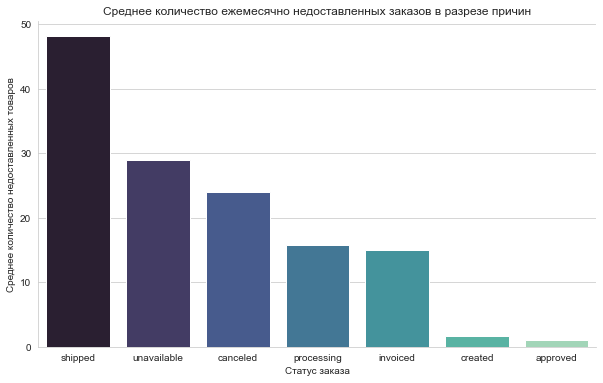

In [32]:
# Визуализируем полученный результат
plt.figure(figsize=(10, 6))
data=undelivered_mean.sort_values('mean_undelivered', ascending=False)
ax = sns.barplot(x='order_status', y='mean_undelivered', data=data, palette = 'mako')

ax.set(title='Среднее количество ежемесячно недоставленных заказов в разрезе причин',
       xlabel='Статус заказа', 
       ylabel='Среднее количество недоставленных товаров')
sns.despine();

**Таким образом, в среднем, в течение месяца не доставляется 135 заказов, при этом больше всего не доставляется заказов по причине отгрузки со склада, отмены заказа и отсутствия товара на складе.**

<hr>

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.


Для того чтобы решить поставленную задачу необходимо объединить датафреймы по заказам и товарам. Поскольку в процессе решения задачи №2 мы выяснили, что существует ряд причин, по которым пользователям не доставляются товары - будем руководствоваться **Предположением 3** (задача №1) и считать покупкой **только доставленные** пользователю товары. День недели получим из столбца ```order_approved_at```, т.е. днем покупки будем считать фактическое поступление денежных средств а не дату фактической доставки товара.

In [33]:
# Объединим данные по заказам и товарам и отобразим первые 5 строк
goods = pd.merge(items, orders, on='order_id')
goods.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


In [34]:
# Посмотрим на количество уникальных значений по id товаров и заказов
goods[['order_id', 'order_item_id', 'product_id']].nunique()

order_id         98666
order_item_id       21
product_id       32951
dtype: int64

Таким образом, у нас более 30 000 уникальных товаров, для которых необходимо найти день с наибольшей частатой покупок.

In [35]:
# Создадим дополнительный столбец с названием дня недели "покупки" товара
goods['purchase_day'] = goods.order_approved_at.dt.day_name()
goods.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_day
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,Saturday


In [36]:
# Рассчитаем частоту покупок по дням для каждого товара и отобразим первые пять строк
purchase_frequency_df = goods.query('order_status == "delivered" & order_approved_at !="NaT"') \
        .groupby(['product_id', 'purchase_day'], as_index=False) \
        .agg(highest_frequency=('order_id', 'count')) \
        .sort_values('highest_frequency', ascending=False) \
        .groupby('product_id') \
        .head(1) \
        .reset_index() \
        .drop(columns='index')

purchase_frequency_df.head()

,product_id,purchase_day,highest_frequency
0,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
1,53b36df67ebb7c41585e8d54d6772e08,Tuesday,104
2,422879e10f46682990de24d770e7f83d,Tuesday,89
3,368c6c730842d78016ad823897a372db,Thursday,80
4,99a4788cb24856965c36a24e339b6058,Tuesday,78


In [37]:
# Посмотрим также какая частота получилась по дням недели по всем продуктам за весь период
purchase_days = goods.query('order_status == "delivered" & order_approved_at !="NaT"') \
        .groupby('purchase_day', as_index=False) \
        .agg(total_number=('product_id', 'count'))

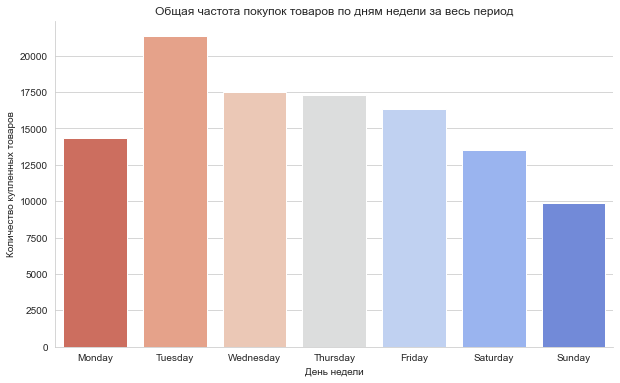

In [38]:
# Визуализируем общую частату покупок всех товаров по дням недели
plt.figure(figsize=(10, 6))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.barplot(x='purchase_day', y='total_number', data=purchase_days, palette = 'coolwarm_r', order=order)

ax.set(title='Общая частота покупок товаров по дням недели за весь период',
       xlabel='День недели', 
       ylabel='Количество купленных товаров')
sns.despine();

<hr>

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.


Для того чтобы решить поставленную задачу воспользуемся объединенным датафреймом по заказам и товарам ```sales_df``` (Задача №2). На этом шаге также будем руководствоваться **Предположением 3** (задача №1) и считать покупкой только доставленные пользователю товары. День недели получим из столбца ```order_approved_at```, т.е. днем покупки будем считать фактическое поступление денежных средств а не дату фактической доставки товара. При этом не будем учитывать заказы, которые имеют статус ```delivered```, но отсутствует дата поступления оплаты (возможно, эти данные содержат ошибку) - всего таких строк ```14 = sales_df.query('order_status == "delivered" & order_approved_at =="NaT"').shape[0]```.

In [39]:
# Отберем нужные данные, удалим ненужные столбцы и создадим столбец с годом и месяцем зачисления оплаты
df = sales_df.query('order_status == "delivered" & order_approved_at !="NaT"').drop(columns=['year', 'month'])
df['year_month'] = df.order_approved_at.dt.to_period('M')
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [40]:
# Сгруппируем данные по customer_unique_id и year_month и посчитаем сколько в месяц у каждого пользователя было покупок
purchases_weekly = df.groupby(['customer_unique_id', 'year_month'], as_index=False) \
        .agg(orders_quantity=('order_id', 'count'))

# Добавим столбец с количеством недель в определенный месяц
purchases_weekly['weeks_quantity'] = (purchases_weekly.set_index('year_month').index.days_in_month) / 7

# Рассчитаем среднее количество покупок в определенный месяц
purchases_weekly['perchases_by_week'] = (purchases_weekly.orders_quantity / purchases_weekly.weeks_quantity).round(2)

# Добавим отельные столбцы с годом и месяцем
purchases_weekly['year'] = purchases_weekly.year_month.dt.year
purchases_weekly['month'] = purchases_weekly.year_month.dt.month

# Удалим ненужный столбец и посмотрим на наши данные
purchases_weekly.drop(columns='year_month', inplace=True)
purchases_weekly.head()

,customer_unique_id,orders_quantity,weeks_quantity,perchases_by_week,year,month
0,0000366f3b9a7992bf8c76cfdf3221e2,1,4.428571,0.23,2018,5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,4.428571,0.23,2018,5
2,0000f46a3911fa3c0805444483337064,1,4.428571,0.23,2017,3
3,0000f6ccb0745a6a4b88665a16c9f078,1,4.428571,0.23,2017,10
4,0004aac84e0df4da2b147fca70cf8255,1,4.285714,0.23,2017,11


На примере пользователя ```customer_unique_id = 8d50f5eadf50201ccdcedfb9e2ac8455```, который встречается  в датафрейме ```customers``` наибольшее количество раз, посмотрим среднее количество покупок в неделю на протяжении всего анализируемого периода.

In [41]:
purchases_weekly.query('customer_unique_id == "8d50f5eadf50201ccdcedfb9e2ac8455"')

,customer_unique_id,orders_quantity,weeks_quantity,perchases_by_week,year,month
52416,8d50f5eadf50201ccdcedfb9e2ac8455,1,4.285714,0.23,2017,6
52417,8d50f5eadf50201ccdcedfb9e2ac8455,2,4.428571,0.45,2017,7
52418,8d50f5eadf50201ccdcedfb9e2ac8455,1,4.428571,0.23,2017,8
52419,8d50f5eadf50201ccdcedfb9e2ac8455,1,4.285714,0.23,2017,9
52420,8d50f5eadf50201ccdcedfb9e2ac8455,2,4.428571,0.45,2017,10
52421,8d50f5eadf50201ccdcedfb9e2ac8455,1,4.285714,0.23,2017,11
52422,8d50f5eadf50201ccdcedfb9e2ac8455,2,4.428571,0.45,2018,5
52423,8d50f5eadf50201ccdcedfb9e2ac8455,2,4.428571,0.45,2018,7
52424,8d50f5eadf50201ccdcedfb9e2ac8455,3,4.428571,0.68,2018,8


Как видно из полученного результата, пользователь ```8d50f5eadf50201ccdcedfb9e2ac8455``` совершал различное количество покупок по месяцам как в 2017 г., так и в 2018 г.

In [42]:
# Сделаем сводную таблицу среднего количества покупок в неделю по каждому месяцу
perchases_table = pd.pivot_table(purchases_weekly, index='customer_unique_id', 
                     columns=['year', 'month'], values='perchases_by_week', fill_value='')

perchases_table[:10]

year                             2016       2017                       ...  \
month                              9  10 12   1  2     3  4  5  6  7   ...   
customer_unique_id                                                     ...   
0000366f3b9a7992bf8c76cfdf3221e2                                       ...   
0000b849f77a49e4a4ce2b2a4ca5be3f                                       ...   
0000f46a3911fa3c0805444483337064                     0.23              ...   
0000f6ccb0745a6a4b88665a16c9f078                                       ...   
0004aac84e0df4da2b147fca70cf8255                                       ...   
0004bd2a26a76fe21f786e4fbd80607f                                       ...   
00050ab1314c0e55a6ca13cf7181fecf                                       ...   
00053a61a98854899e70ed204dd4bafe                                       ...   
0005e1862207bf6ccc02e4228effd9a0                     0.23              ...   
0005ef4cd20d2893f0d9fbd94d3c0d97                                       ...   

year                                      2018                                \
month                               11 12   1     2     3     4     5  6  7    
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2                                  0.23         
0000b849f77a49e4a4ce2b2a4ca5be3f                                  0.23         
0000f46a3911fa3c0805444483337064                                               
0000f6ccb0745a6a4b88665a16c9f078                                               
0004aac84e0df4da2b147fca70cf8255  0.23                                         
0004bd2a26a76fe21f786e4fbd80607f                            0.23               
00050ab1314c0e55a6ca13cf7181fecf                            0.23               
00053a61a98854899e70ed204dd4bafe                0.25                           
0005e1862207bf6ccc02e4228effd9a0                                               
0005ef4cd20d2893f0d9fbd94d3c0d97                      0.23                     

year                                 
month                            8   
customer_unique_id                   
0000366f3b9a7992bf8c76cfdf3221e2     
0000b849f77a49e4a4ce2b2a4ca5be3f     
0000f46a3911fa3c0805444483337064     
0000f6ccb0745a6a4b88665a16c9f078     
0004aac84e0df4da2b147fca70cf8255     
0004bd2a26a76fe21f786e4fbd80607f     
00050ab1314c0e55a6ca13cf7181fecf     
00053a61a98854899e70ed204dd4bafe     
0005e1862207bf6ccc02e4228effd9a0     
0005ef4cd20d2893f0d9fbd94d3c0d97     

[10 rows x 23 columns]

In [43]:
# Посчитаем общее среднее значение количества покупок в неделю для каждого покупателя
mean_weekly = purchases_weekly.groupby('customer_unique_id', as_index=False) \
                .agg(mean_perchases_by_week=('perchases_by_week', 'mean'))

mean_weekly.head()

,customer_unique_id,mean_perchases_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.23
2,0000f46a3911fa3c0805444483337064,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,0.23
4,0004aac84e0df4da2b147fca70cf8255,0.23


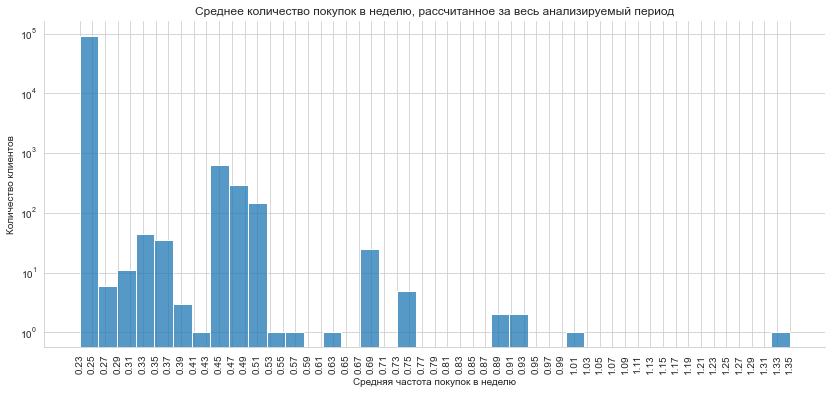

In [44]:
# Посмотрим на распределение общего среднего значения количества покупок в неделю
plt.figure(figsize=(14, 6))
bins = round(1 + 3.2 * np.log(mean_weekly.shape[0]))
ax = sns.histplot(data=mean_weekly, x='mean_perchases_by_week', bins=bins)
ax.set_xticks(np.arange(0.23, 1.35, 0.02))
ax.set_yscale('log')
plt.xticks(rotation=90)


ax.set(title='Среднее количество покупок в неделю, рассчитанное за весь анализируемый период',
       xlabel='Средняя частота покупок в неделю', 
       ylabel='Количество клиентов')
sns.despine();

**Как видно из гистограммы, у большей части покупателей общее среднее значение количество покупок в неделю не превышает 0.25**

<hr>

## 5. Реализовать функцию, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.


```Customer retention``` (удержание клиентов) - это способность компании удерживать своих потребителей в течение определенного периода времени. Успех в удержании клиентов измеряется показателем **Retention Rate** (коэффициент удержания клиентов). Поскольку пользователи будут объединятся в когорты по **RR**, будем учитывать не только доставленные заказы, но и заказы с другими статусами, т.к. условный пользователь в одном из месяцев мог купить товар, в следующем отменить свой заказ, а через два месяца не получить заказ из-за того что товара нет в наличии. Таким образом, пользователь с определенной периодичностью  совершает целевые действия. А это означает, что если мы будем учитывать только заказы со статусом ```delivered```, мы потеряем часть информации.


Воспользуемся объединенным датафреймом по заказам и товарам ```sales_df``` (Задача №2).

In [45]:
def cohort_analysis(data, ids_col, target_col):
    """Функция для построения кагортного анализа.
    Рассчитывает коэффициент удержания клиентов (Retention Rate) и
    возвращает матрицу кагорт 'год-месяц' с временным интервалом месяц. 
    
    Параметры
    ---------
    data: pandas DataFrame
        Датасет
    ids_col: str
        Поле с id клиентов/пользователей. Тип данных: object, int64
    target_col: str
        Поле с датой покупки/регистрации и т.п. Тип данных datetime64[ns]
    """
    # создается промежуточный датасет, чтобы не изменять изначальный датасет
    df = data[[ids_col]]
    
    # создается дополнительный столбец с периодом целевого действия
    df['order_month'] = data[target_col].dt.to_period('M')
    
    # формируется кагорта с наименьшей датой совершения целевого действия пользователем
    df['cohort'] = data.groupby(ids_col)[target_col].transform('min').dt.to_period('M')
    
    # рассчитывается количество уникальных пользователей в каждой группе
    df_cohort = df.groupby(['cohort', 'order_month'], as_index=False).agg(n_customers=(ids_col, 'nunique'))
    
    # рассчитывается период между месяцем кагорты и месяцем совершения целевого действия
    df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
    
    # создается сводная таблица по рассчитанным показателям
    cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
    
    # переменная с размером кагорты
    cohort_size = cohort_pivot.iloc[:, 0]
    
    # рассчитывается коэффициент удержания клиентов
    matrix = cohort_pivot.divide(cohort_size, axis = 0)
     
    # задает цветовое форматирование и заголовок
    retention_matrix = (matrix
            .style
            .set_caption('Коэффициент удержания клиентов по кагортам')
            .background_gradient(cmap='YlGnBu')
            .highlight_null('white')
            .format("{:.2%}", na_rep=''))
    
    return retention_matrix

In [46]:
# Строим кагортный анализ для наших данных
cohort_analysis(sales_df, 'customer_unique_id', 'order_purchase_timestamp')

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.31%,,,0.31%,,0.31%,,0.31%,,0.31%,,0.31%,0.62%,0.62%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%,
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%,,
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%,,
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,,,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,,,


**Анализ матрыцы показывает, что в период с января по декабрь когорта с самым высоким retention на 3-й месяц это кагорта ```2017-06```.**

<hr>

## 6. Построить RFM-кластеры для пользователей. Вывести для каждого кластера средние значения метрик R, F, M (и описать подробно, как были построены метрики R, F, M).



**RFM-анализ** - метод анализа, позволяющий сегментировать клиентов по частоте и сумме покупок и выявлять тех, которые приносят больше денег.

Аббревиатура RFM расшифровывается:
- **Recency** - давность (как давно ваши клиенты что-то у вас покупали);
- **Frequency** - частота (как часто они у вас покупают);
- **Monetary** - деньги (общая сумма покупок).

Суть RFM-анализа в том, что мы разделяем всех клиентов на группы, в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. По каждому из этих признаков мы выделяем по $n$ равных групп. Затем присваиваем каждой группе числовое обозначение от 1 до $n$. Рассмотрим пример при $n=3$.

По давности заказа:
- 1 - давние клиенты;
- 2 - относительно недавние клиенты;
- 3 - недавние клиенты.

По частоте покупок:
- 1 - покупает очень редко (единичные заказы);​
- 2 - покупает нечасто;
- 3 - покупает часто.

По сумме покупок:
- 1 - маленькая сумма покупок;
- 2 - средняя сумма покупок;
- 3 - большая сумма покупок.

Например, клиент «111» покупал давно, один раз и на маленькую сумму. Или клиент «333»: покупает часто, на большую сумму и последняя покупка была недавно.

<hr>

In [47]:
# Объединим данные и удалим нерелевантные столбы и посмотрим на первые 5 строк общих данных
columns_to_drop = ['shipping_limit_date', 'customer_id', 'seller_id', 'customer_zip_code_prefix', 'year', 'month',
                  'customer_city', 'customer_state', 'order_delivered_carrier_date', 'order_estimated_delivery_date']

full_df = pd.merge(items, sales_df, on='order_id').drop(columns=columns_to_drop)
full_df.head()

,order_id,order_item_id,product_id,price,freight_value,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,871766c5855e863f6eccc05f988b23cb,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,eb28e67c4c0b83846050ddfb8a35d051,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-12 16:04:24
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,3818d81c6709e39d06b2738a8d3a2474,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-22 13:19:16
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,af861d436cfc08b2c2ddefd0ba074622,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-14 13:32:39
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,64b576fb70d441e8f1b2d7d446e483c5,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-03-01 16:42:31


Для решения этой задачи также будем руководствоваться Предположением 3 (задача №1) и считать покупкой только доставленные пользователю товары (в задаче №2 было установлено, что не все заказы доставляются клиентам по ряду причин). Днем покупки будем считать дату из столбца ```order_approved_at```. При этом не будем учитывать заказы, которые имеют статус ```delivered```, но отсутствует дата поступления оплаты (возможно, эти данные содержат ошибку) - всего таких строк ```15 = full_df.query('order_status == "delivered" & order_approved_at =="NaT"').shape[0]```.

In [48]:
full_df = full_df.query('order_status == "delivered" & order_approved_at !="NaT"')

In [49]:
# Посмотрим на минимальную и максимальную даты поступления оплаты в наших данных
min_date = full_df.order_approved_at.min()
max_date = full_df.order_approved_at.max()
print(f'Min Payment Date: {min_date} \nMax Payment Date: {max_date}')

Min Payment Date: 2016-09-15 12:16:38 
Max Payment Date: 2018-08-29 15:10:26


Рассчитаем **RFM** метрики для каждого клиента, для этого сгруппируем данные по ```customer_unique_id```, определим самую позднюю дату покупки с момента последней записи в наших данных (```2018-08-29```), посчитаем общее количество покупок за весь анализируемый период, и суммируем суммы покупок для каждого клиента.<br>
К максимальной дате в имеющихся данных добавим один день, таким образом мы получим самую маленькую разницу в один день. Т.е. будем анализировать ```recency``` как будто "сегодня" делаем анализ за "вчерашний день".

In [50]:
# Добавим один день к самой поздней дате в наших данных
max_date = max_date + dt.timedelta(days=1)

# Посчитаем RFM метрики
rfm_df = full_df.groupby(['customer_unique_id'], as_index=False) \
        .agg(recency=('order_approved_at', lambda x : (max_date - x.max()).days),
             frequency=('order_id', 'count'), 
             monetary_value=('price', 'sum'))

rfm_df.head()

,customer_unique_id,recency,frequency,monetary_value
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [51]:
# Посмотрим на описательную статистику по полученным метрикам
rfm_df.describe(percentiles=[0, 1/6, 1/3, .5, 2/3, 5/6, 1]).T.round(2)

,count,mean,std,min,0%,16.7%,33.3%,50%,66.7%,83.3%,100%,max
recency,93345.0,237.48,152.57,1.00,1.00,76.0,148.0,219.00,289.0,407.0,714.0,714.0
frequency,93345.0,1.18,0.62,1.00,1.00,1.0,1.0,1.00,1.0,1.0,24.0,24.0
monetary_value,93345.0,141.62,215.71,0.85,0.85,34.9,58.9,89.76,127.9,199.9,13440.0,13440.0


Таким образом:
- меньше 17% клиентов сделали покупки за последние 75 дней 
- у 80% клиентов не более 1-й покупки
- у 80% общая сумма покупки не превышает 200 ден.ед.

Следующий шаг - определить в группах recency, frequency и monetary категории, обозначив цифрами от 1 до $n$. 

Поскольку у нас небольшое количество клиентов, которые покупали относительно недавно, не так много клиентов с большей частотой покупки чем одна и суммой покупки не превышающей 200 ден. ед., разделим клиентов на 4 категории.

Оценим «Давность» для клиента, который был активен совсем недавно выше чем клиент, который был активен очень давно. «Частоту» и «Денежную ценность» будем оценивать выше с увеличением этим переменных, потому что мы хотим, чтобы клиент тратил больше денег и посещал чаще. Таким образом:

- Лучшая оценка ```Recency``` = 4 (покупка была совсем недавно)
- Лучшая оценка ```Frequency``` = 4 (самая большая частота покупок)
- Лучшая оценка ```Monetary```= 4 (самая большая сумма покупки)

Воспользуемся функцией ```pd.qcut``` для вычисления размера каждого интервала, чтобы гарантировать, что распределение данных в интервалах одинаково. Другими словами, все интервалы будут иметь (примерно) одинаковое количество наблюдений.

Для вычисления категорий для _frequency_ воспользуемся дополнительной функцией ```f_category``` -  зададим категории вручную, т.к. частота покупок равная 1 у 83% покупателей и разделить все наблюдения на равные интервалы не представляется возможным. В итоге у нас получится разделение на НЕРАВНЫЕ интервалы, что разумеется не совсем правильно, однако в данном случае, считаю такой подход оправданным.

In [52]:
# Посчитаем значения частоты покупок
rfm_df.frequency.value_counts().to_frame().T

,1,2,3,4,5,6,7,8,10,11,9,12,14,15,13,20,21,18,24
frequency,81737,8795,1646,621,241,190,45,16,11,11,10,9,3,3,2,2,1,1,1


In [53]:
# Определим функцию, которая будет определять категорию в зависимости от частоты покупок
def f_category(df):
    if df['frequency'] == 1:
        return 1
    elif df['frequency'] == 2:
        return 2
    elif df['frequency'] == 3:
        return 3
    else:
        return 4

In [54]:
# Определим категории для RFM метрик
rfm_df['R'] = pd.qcut(rfm_df['recency'], q=4, labels=np.arange(4, 0, -1))
rfm_df['F'] = rfm_df.apply(f_category, axis=1)
rfm_df['M'] = pd.qcut(rfm_df['monetary_value'], q=4, labels=np.arange(1, 5))

rfm_df.head()

,customer_unique_id,recency,frequency,monetary_value,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,4,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4


Добавим в имеющийся датафрейм два дополнительных столбца:
- ```rfm_segment``` - сегмент к которому относится клиент (кодовое значение метрик R, F и M)
- ```rfm_score``` - суммарное количество по столбцам R, F и M (чем больше, тем лучше)

In [55]:
# Определим функцию которая будет складывать столбцы как строковые значения
def add_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

# Добавим в rfm_df два дополнительных столбца
rfm_df['rfm_segment'] = rfm_df.apply(add_rfm, axis=1)
rfm_df['rfm_score'] = rfm_df[['R','F','M']].sum(axis=1)

rfm_df.head()

,customer_unique_id,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,3,413,8
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,4,1,1,411,6
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,4
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,4
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214,7


In [56]:
# Посмотрим на 15 самых больших сегментов
rfm_df.rfm_segment.value_counts()[:15].to_frame().rename(columns={'rfm_segment': 'segment_size'}).T

,111,411,311,212,112,211,412,413,312,313,213,113,114,414,214
segment_size,5683,5679,5641,5501,5341,5328,5285,5266,5175,5146,4926,4892,4590,4469,4459


In [57]:
# Посмотрим на средние значения по rfm_score
rfm_df.groupby('rfm_score') \
    .agg({'recency': 'mean',
          'frequency': 'mean',
          'monetary_value': ['mean', 'count']}) \
    .round(2)

recency frequency monetary_value       
             mean      mean           mean  count
rfm_score                                        
3          454.34      1.00          28.66   5683
4          363.74      1.02          46.46  10933
5          297.11      1.04          67.21  16718
6          234.06      1.06         131.43  21664
7          180.50      1.15         167.09  17177
8          130.94      1.26         219.10  12109
9           95.55      1.49         323.15   6676
10         108.46      2.73         342.66   1615
11         107.91      4.26         404.38    525
12          61.96      5.29         538.38    245

### Анализ сегментации RFM

Поскольку неизвестна специфика e-commerce, определить сегменты для наилучшего описания кластеров клиентов затруднительно. Однако из предыдущего анализа можно сделать следующие выводы:
- самые большие сегменты - это клиенты, которые разово делали покупки, т.е. купили товар, удовлетворили свою потребность и больше не возвращались;
- суммы покупок у самых больших сегментов также небольшие.

Определим наши сегменты, на основании наиболее распространенных подходов, использующихся при RFM-анализе:

- **Лучшие клиенты** (444) — это лучшие клиенты, которые покупают чаще всего, последние покупки были совсем недавно, а также активно тратят деньги.
- **Клиенты, которые много покупают** (334) — это недавние клиенты с высокой частотой и потратившие приличную сумму.
- **Недавние клиенты** (443) — это недавние клиенты с высокой частотой и потратившие достаточную сумму.
- **Почти потерянные клиенты** (244) — это клиенты, которые имеют высокий общий балл RFM, но делали покупки относительно давно.
- **Потерянные клиенты** (144) — это клиенты, которые часто делали покупали и тратили большие суммы, но уже давно не совершали покупок.
- **Потерянные клиенты с небольшой суммой покупки** (122) — это клиенты, которые не часто делали покупки, тратили небольшие суммы и уже давно не совершали покупок.

Остальных клиентов, которые не попадут в описанные категории, определим в категорию **Обычный клиент** (Normal).<br>
[Источник 1](https://clevertap.com/blog/rfm-analysis/)<br>
[Источник 2](https://www.moengage.com/blog/rfm-analysis-using-rfm-segments/)

In [58]:
# Создадим словарь для описанных категорий
segment_dict = {
    '444': 'Best Customers',
    '334': 'Big Spenders',
    '244': 'Almost Lost',
    '144': 'Lost Customers',
    '443': 'Recent Customers',
    '122': 'Lost Cheap Customers'
}

In [59]:
# Определим категории для сегментов
rfm_df['segment'] = rfm_df.rfm_segment.map(lambda x: segment_dict.get(x))
rfm_df.segment.fillna('Normal', inplace=True)
rfm_df.head()

,customer_unique_id,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,3,413,8,Normal
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,4,1,1,411,6,Normal
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,4,Normal
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,4,Normal
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214,7,Normal


In [60]:
# Сгруппируем сегменты и рассчитаем средние показатели по метрикам
segmented = rfm_df.groupby('segment') \
    .agg({'recency': 'mean',
          'frequency': 'mean',
          'monetary_value': ['mean', 'count']}) \
    .round(2)

segmented.columns = ['recency_mean','frequency_mean','monetary_mean', 'size']
segmented.reset_index(inplace=True)
segmented

,segment,recency_mean,frequency_mean,monetary_mean,size
0,Almost Lost,284.33,5.17,596.84,203
1,Best Customers,61.96,5.29,538.38,245
2,Big Spenders,167.53,3.00,330.60,253
3,Lost Cheap Customers,452.66,2.00,67.27,461
4,Lost Customers,456.30,4.81,465.97,172
5,Normal,236.64,1.14,138.82,91965
6,Recent Customers,59.17,4.57,116.31,46


**Таким образом:**
- **наш типичный клиент - это клиент с одной покупкой и небольшим средним чеком;**
- **очень мало клиентов, которые совсем недавно что-то у нас покупали;**
- **ядро "активных покупателей" с высоким чеком составляет всего 245 клиентов.**

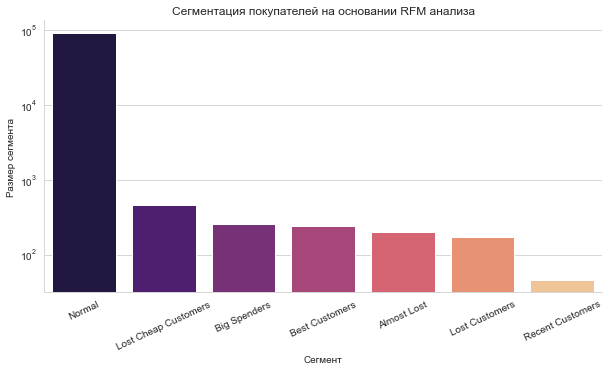

In [61]:
# Визуализируем результат
plt.figure(figsize=(10, 5))
order = ['Normal', 'Lost Cheap Customers', 'Big Spenders', 'Best Customers', 
         'Almost Lost', 'Lost Customers', 'Recent Customers']

ax = sns.barplot(x='segment', y='size', data=segmented, order=order, palette = 'magma',)
ax.set_yscale('log')
plt.xticks(rotation=25)

ax.set(title='Сегментация покупателей на основании RFM анализа',
       xlabel='Сегмент', 
       ylabel='Размер сегмента')

sns.despine();

<hr>

## RFM-кластеризация клиентов с использованием K-Means


Метод $k$-средних (k-Means Clustering) – это очень известный и мощный алгоритм Обучения без учителя (Unsupervised Learning), который группирует похожие элементы в $k$ кластеров.

**Нахождение оптимального количества кластеров**<br>
Воспользуемся  _Методом локтя (Elbow Rule)_ – одним из самых популярных методов, с помощью которого можно выбрать оптимальное значение $k$

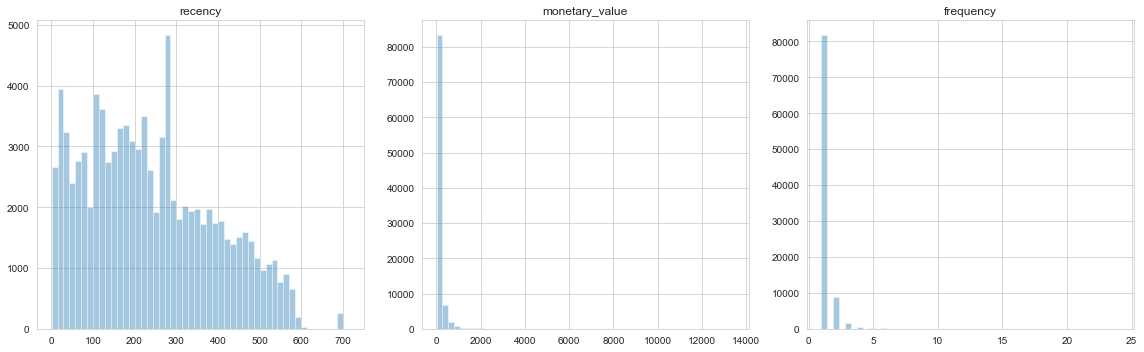

In [62]:
# Посмотрим на распределения RFM метрик
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 5))

for ax, col in zip(axes.flatten(), ['recency', 'monetary_value', 'frequency']):
    sns.distplot(rfm_df[col], kde=False, ax=ax)
    ax.set(xlabel='')
    ax.set(title=col)
    
plt.tight_layout();

In [63]:
# Приведем метрики к единой шкале
rfm = rfm_df[['recency', 'monetary_value', 'frequency']]
scaled_data = MinMaxScaler().fit_transform(rfm)

In [64]:
# Определим оптимальное количество кластеров с помощью k-means
n_clusters = np.arange(2, 10)
clusters_inertia = []
s_scores = []

for n in n_clusters:
    k_means = KMeans(init='k-means++', n_clusters=n, max_iter=50).fit(scaled_data)
    clusters_inertia.append(k_means.inertia_)

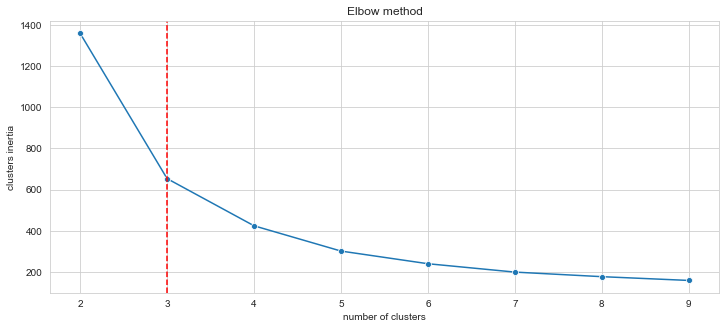

In [65]:
# Посмотрим на график метода локтя
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, clusters_inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(3, ls="--", c="red");

Таким образом наиболее оптимальное количество кластеров $ k = 3 $.

In [66]:
# Обучим алгоритм и добавим метки кластеров в rfm_df
kmeans = KMeans(init='k-means++', n_clusters=3).fit(scaled_data)
cluster_labels = kmeans.labels_ + 1
rfm_df['cluster_id'] = cluster_labels
rfm_df.head()

,customer_unique_id,recency,frequency,monetary_value,R,F,M,rfm_segment,rfm_score,segment,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,3,413,8,Normal,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,4,1,1,411,6,Normal,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,4,Normal,3
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,4,Normal,2
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214,7,Normal,2


In [67]:
# Сгруппируем данные по кластерам и посмотрим на средние значения метрик
rfm_df.groupby('cluster_id') \
    .agg({'recency': 'mean',
          'frequency': 'mean',
          'monetary_value': ['mean', 'count']}) \
    .round(2)

recency frequency monetary_value       
              mean      mean           mean  count
cluster_id                                        
1            87.25      1.19         144.60  36199
2           255.21      1.18         138.57  35284
3           457.61      1.16         141.63  21862

In [68]:
# Добавим метки классов и масштабированные данные в датафрейм
rfm_scaled = pd.DataFrame(scaled_data, index = rfm_df.customer_unique_id, columns = rfm.columns).reset_index()
rfm_scaled['k_cluster'] = cluster_labels
rfm_scaled.drop(columns='customer_unique_id', inplace=True)

rfm_scaled.head()

,recency,monetary_value,frequency,k_cluster
0,0.155680,0.009603,0.0,1
1,0.158485,0.001343,0.0,1
2,0.751753,0.005071,0.0,3
3,0.448808,0.001871,0.0,2
4,0.402525,0.013330,0.0,2


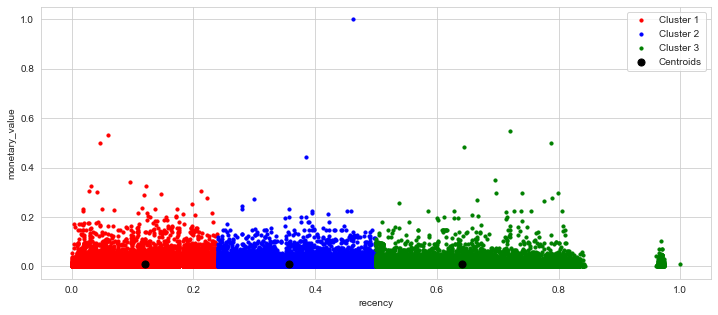

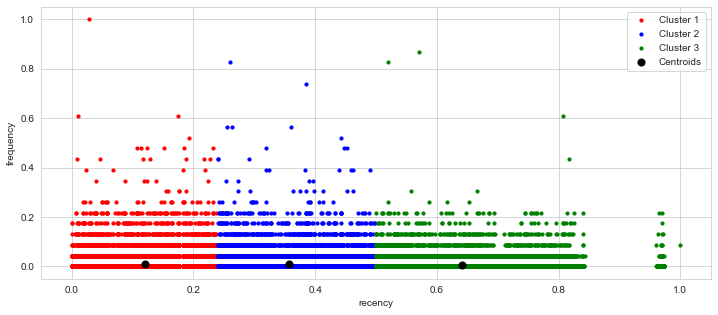

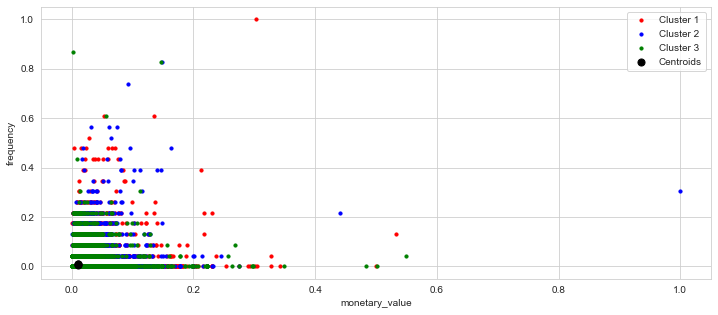

In [69]:
# Визуализируем полученный результат
X = rfm_scaled.iloc[:, 0:3].values
count = X.shape[1]
for i in range(0, count):
    for j in range(i+1, count):
        plt.figure(figsize=(12, 5));
        plt.scatter(X[cluster_labels == 1, i], X[cluster_labels == 1, j], s = 10, c = 'red', label = 'Cluster 1')
        plt.scatter(X[cluster_labels == 2, i], X[cluster_labels == 2, j], s = 10, c = 'blue', label = 'Cluster 2')
        plt.scatter(X[cluster_labels == 3, i], X[cluster_labels == 3, j], s = 10, c = 'green', label = 'Cluster 3')
        plt.scatter(kmeans.cluster_centers_[:, i], kmeans.cluster_centers_[:, j], s = 50, c = 'black', label = 'Centroids')
        plt.xlabel(rfm_scaled.columns[i])
        plt.ylabel(rfm_scaled.columns[j])
        plt.legend();

**Таким образом, алгоритм кластеризации K-Means позволяет сегментировать клиентов на 3 большие группы. При этом полученные кластеры не очень хорошо отражают поведенческие паттерны. Логарифмирование и последующая нормализация переменных с помощью ```StandardScaler()``` не сказывается на улучшении результатов K-Means.**

**В рассматриваемом примере, аналитический подход к кластеризации на основании агрегированных метрик  (```rfm_segment```) позволяет получить более детальную информацию.**